In [1]:
import json

import wandb

import pandas as pd
import matplotlib.pyplot as plt

/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/home/david/miniconda3/envs/aicomp/lib/python3.12/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened bec

In [2]:
wandb.login()
api = wandb.Api()

WANDB_PROJECT_ENTITY = "hms-hslu-aicomp-hs25"
WANDB_PROJECT_NAME = "hms-aicomp-cnn-architectures"

wandb: Currently logged in as: davidhodel (hms-hslu-aicomp-hs25) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [3]:
runs = api.runs(f"{WANDB_PROJECT_ENTITY}/{WANDB_PROJECT_NAME}")
print(f"Found {len(runs)} runs")

Found 50 runs


In [4]:
runs_data = []
for run in runs:
    run_config = json.loads(run.config)
    run_metrics = json.loads(run.summary_metrics)

    run_dict = {
        "id": run.id,
        "name": run.name,
        "fold": run_config["fold"]["value"],
        "architecture": run_config["architecture"]["value"],
        "val_kl_div": run_metrics["best_val_kl_div"],
        "runtime": run_metrics["_runtime"],
    }
    runs_data.append(run_dict)

runs_df = pd.DataFrame(runs_data)
runs_df

,id,name,fold,architecture,val_kl_div,runtime
0,cfy7ku2n,tf_efficientnet_b0_ns-spec-fold0,0,tf_efficientnet_b0_ns,0.894191,1744
1,xa2svcwl,tf_efficientnet_b0_ns-spec-fold1,1,tf_efficientnet_b0_ns,0.705867,1722
2,mbx7frv4,tf_efficientnet_b0_ns-spec-fold2,2,tf_efficientnet_b0_ns,0.716440,1723
3,83eppbdd,tf_efficientnet_b0_ns-spec-fold3,3,tf_efficientnet_b0_ns,0.762536,1681
4,roedsfxd,tf_efficientnet_b0_ns-spec-fold4,4,tf_efficientnet_b0_ns,0.760839,1656
5,b1sck8y0,tf_efficientnet_b1_ns-spec-fold0,0,tf_efficientnet_b1_ns,0.918853,2076
6,3nsr6126,tf_efficientnet_b1_ns-spec-fold1,1,tf_efficientnet_b1_ns,0.720007,2082
7,sah65iba,tf_efficientnet_b1_ns-spec-fold2,2,tf_efficientnet_b1_ns,0.744245,2089
8,i4sanc1j,tf_efficientnet_b1_ns-spec-fold3,3,tf_efficientnet_b1_ns,0.755363,2104
9,09g7h6n0,tf_efficientnet_b1_ns-spec-fold4,4,tf_efficientnet_b1_ns,0.778415,2099


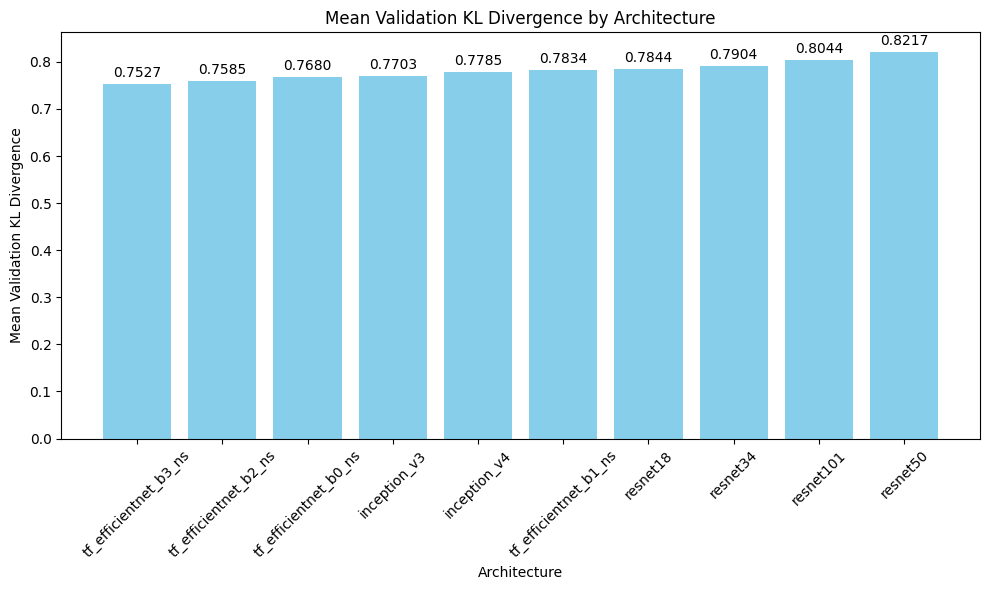

In [5]:
performance_df = runs_df.groupby("architecture")["val_kl_div"].mean().sort_values()

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(performance_df.index, performance_df.values, color='skyblue')
ax.set_xlabel("Architecture")
ax.set_ylabel("Mean Validation KL Divergence")
ax.set_title("Mean Validation KL Divergence by Architecture")
ax.bar_label(bars, fmt='%.4f', padding=3)
plt.xticks(rotation=45)
plt.tight_layout()

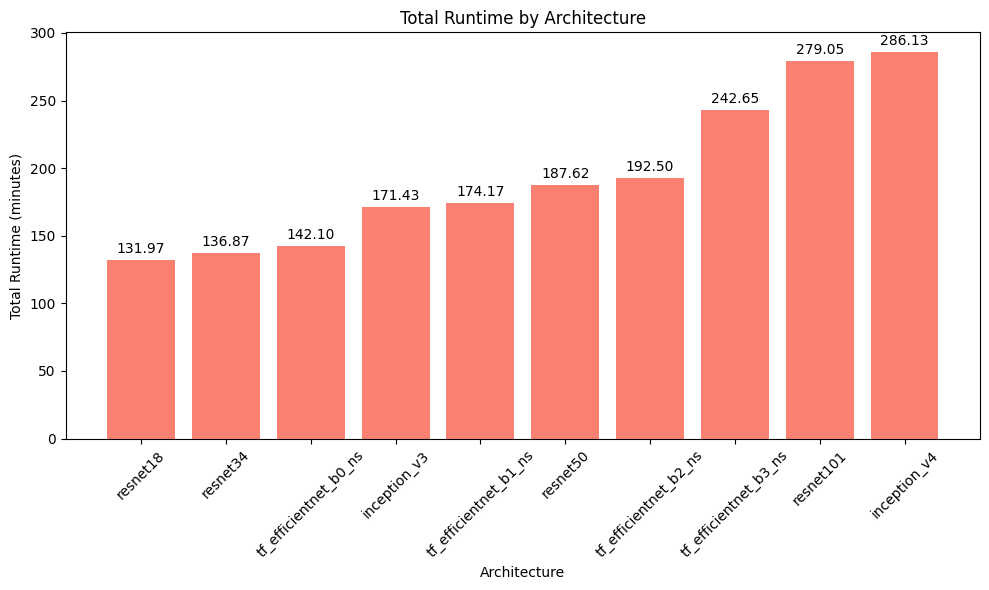

In [6]:
runtime_df = runs_df.groupby("architecture")["runtime"].sum().sort_values()
runtime_df = runtime_df / 60

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(runtime_df.index, runtime_df.values, color='salmon')
ax.set_xlabel("Architecture")
ax.set_ylabel("Total Runtime (minutes)")
ax.set_title("Total Runtime by Architecture")
ax.bar_label(bars, fmt='%.2f', padding=3)
plt.xticks(rotation=45)
plt.tight_layout()